In [7]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from typing import List

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay
from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
import spacy
import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from src.model_testing.datasets import TRAIN, VALIDATION, VALIDATION_LARGE


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
TRAIN.data.head()

,Document ID,Country Name,Document Date,Sheet Name,text,md5hash,is_target,page_num,text_block_id
0,9217,India,2019.0,verified-docs,Credit Guarantee Enhancement Corporation to be...,c56d9933b009cc67fccdc4e335cd48df,True,NaN,NaN
1,9217,India,2019.0,verified-docs,Electricity and clean cooking facility to all ...,c56d9933b009cc67fccdc4e335cd48df,True,NaN,NaN
2,9217,India,2019.0,verified-docs,"1,25,000 kilometers of road length to be upgra...",c56d9933b009cc67fccdc4e335cd48df,True,NaN,NaN
3,9217,India,2019.0,verified-docs,100 new clusters to be setup during 2019-20 wi...,c56d9933b009cc67fccdc4e335cd48df,True,NaN,NaN
4,9217,India,2019.0,verified-docs,o 80 Livelihood Business Incubators (LBIs) and...,c56d9933b009cc67fccdc4e335cd48df,True,NaN,NaN


### spacy vectors & SVM

In [5]:
# !spacy download en_core_web_lg

#### get vectors

In [11]:
nlp = spacy.load("en_core_web_lg")

X_train = np.vstack([doc.vector for doc in nlp.pipe(TRAIN.text)])
X_val = np.vstack([doc.vector for doc in nlp.pipe(VALIDATION.text)])
X_val_large = np.vstack([doc.vector for doc in nlp.pipe(VALIDATION_LARGE.text)])

print(type(X_train))

y_train = TRAIN.targets
y_val = VALIDATION.targets
y_val_large = VALIDATION_LARGE.targets


<class 'numpy.ndarray'>


#### train SVM classifier with a fixed set of parameters

'precision-recall curve (small validation set). average precision: 0.8145480361217585'

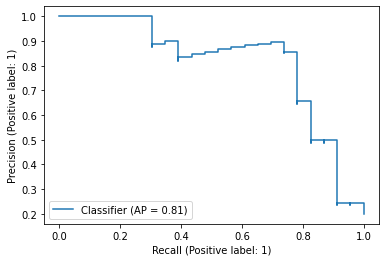

'precision-recall curve (small validation set). average precision: 0.11625916541617318'

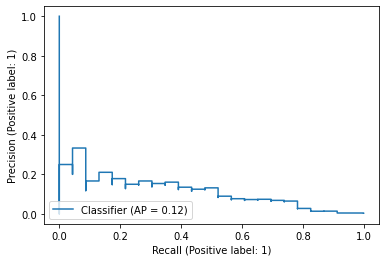

In [17]:
clf = SVC(C=1, gamma=0.5, kernel='rbf', probability=True)

clf = clf.fit(X_train, y_train)

# small validation set 
y_pred_proba = clf.predict_proba(X_val)[:,1]
av_precision = average_precision_score(y_val, y_pred_proba)
display(PrecisionRecallDisplay.from_predictions(y_val, y_pred_proba))
display(f"precision-recall curve (small validation set). average precision: {av_precision}")
plt.show()

print()

y_pred_proba = clf.predict_proba(X_val_large)[:,1]
av_precision = average_precision_score(y_val_large, y_pred_proba)
display(PrecisionRecallDisplay.from_predictions(y_val_large, y_pred_proba))
display(f"precision-recall curve (small validation set). average precision: {av_precision}")
plt.show()


#### grid search on params for above classifier

In [18]:
clf = SVC()

from sklearn.model_selection import GridSearchCV

parameters = [{"C": [1, 10, 100, 1000], "kernel": ['linear'], "class_weight": [None, 'balanced']}, 
              {"C": [1, 10, 100, 1000], "kernel": ['rbf'], 'gamma': [0.5, 0.1, 0.01, 0.001], "class_weight": [None, 'balanced']}]

grid_search = GridSearchCV(
    estimator=clf, 
    param_grid=parameters, 
    scoring='precision', 
    cv=10, 
    n_jobs=-1
)

grid_search = grid_search.fit(X_train, y_train)

#Use attributes of grid_search to get the results
display(grid_search.best_score_)
display(grid_search.best_params_)


0.9477084145940771

{'C': 10, 'class_weight': None, 'gamma': 0.5, 'kernel': 'rbf'}

0.8090279439717494


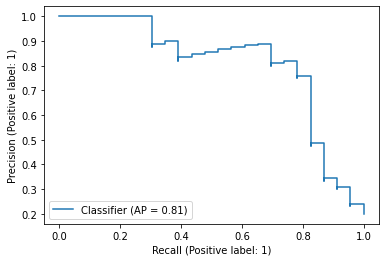

In [19]:
clf = SVC(
    **grid_search.best_params_, 
    probability=True
).fit(
    X_train, 
    y_train,
)

y_pred = clf.predict(X_val)
y_pred_proba = clf.predict_proba(X_val)[:,1]

print(average_precision_score(y_val, y_pred_proba))
display(PrecisionRecallDisplay.from_predictions(y_val, y_pred_proba))
plt.show()


In [20]:
validation = VALIDATION.data
validation['prediction'] = [bool(i) for i in y_pred]

### look at incorrect predictions

In [21]:
fns = validation.loc[validation['is_target'] & ~validation['prediction'], 'text'].tolist()
fps = validation.loc[~validation['is_target'] & validation['prediction'], 'text'].tolist()

fps

['The promotion of socio-economic expansion and poverty reduction throughsignificant use of natural resources in a wasteful and inefficient manner over the pastdecades has put Lao PDR at a high risk of inability to achieve the long-term goals ofthe socio-economic development, such as: graduating from the status of leastdeveloped country in a sustainably manner by 2020, becoming an upper-middleincome country and achieving the Sustainable Development Goals (SDGs) by 2030.Therefore, the Resolution of the 10 th Party Congress, the Vision 2030, the 10-YearStrategy (2016-2025) and the 8 th Five-Year Socio-Economic Development Plan(2016-2020) have given importance and emphasis to the national socio-economicdevelopment of the Lao PDR according to green and sustainable direction. 19',
 "Progress in the preparation of national plans was discussed at several meetings of the Committee of SeniorEnergy Officials of the Baltic Council of Ministers held on 31 January 2018, 9 April 2018, 30 October 201

### run predictions on sample of unlabelled text

In [22]:
import json

def jsonl_to_dataframe(jsonl_path: Path) -> pd.DataFrame:
    """Load the jsonl file produced when running this script as a CLI to a pandas dataframe."""
    with open(jsonl_path, "r") as f:
        data = json.load(f)

    return pd.DataFrame.from_records(data)


In [23]:
all_text = jsonl_to_dataframe("../data/interim/text_passages.jsonl")

In [24]:
text_sample = all_text.sample(1000, random_state=41)

In [25]:
X_sample = np.vstack([doc.vector for doc in nlp.pipe(text_sample['text'].tolist())])
display(X_sample.shape)

y_pred = clf.predict(X_sample)
y_pred_proba = clf.predict_proba(X_sample)

text_sample['pred'] = y_pred
text_sample['pred_proba'] = y_pred_proba[:,1]

display("Top 40 predictions by probability, descending")
with pd.option_context("display.max_colwidth", None):
    display(text_sample.sort_values('pred_proba', ascending=False).loc[:, ['text', 'pred_proba']].head(40))

(1000, 300)

'Top 40 predictions by probability, descending'

,text,pred_proba
597351,Hungary plans to increase the share of energy production based on renewable energy sources within electricity consumption to at least 20 % by 2030.,0.997320
463066,"ii. Estimated trajectories for the sectoral share of renewable energy in final energy consumption from 2021 to 2030 in the electricity, heating and cooling, and transport sector",0.992897
546547,123A whole-of-economy Plan to achieve net zero emissions by 2050,0.987859
597380,", which can significantly increase the amount of national and EU funds serving development, and reduce the energy consumption of buildings and GHG emissions. Pursuant to the directive, district heating/district cooling is deemed to be efficient if operating with at least 50 % renewable energy, 50 % waste heat, 75 % cogenerated heat, or 50 % of a combination of such energy resources.",0.985047
508565,Reviewing the 2017 -2035 Integrated Resource Plan every five years.,0.971286
199679,"By 2040, it is assumed that total GHG emissions from the transport sector will have increased under a scenario with existing measures by approximately 8.2% in comparison to 2016. An increase in road transport is projected. According to estimates, emissions from domestic aviation and railway transport will remain stable from 2016 to 2040. Emissions from domestic shipping are projected to decline because of lower fuel consumption",0.966296
565982,"There are still recently approved sector policy papers which provide for overall objectives related to environmental protection and natural resources management, having actions tangential with biodiversity conservation, especially the National plan for expanding forest vegetation areas for 2014-2018 and the National agricultural and rural development agency for 2014-2020. While the Environmental strategy for 2014-2023 sets out priorities at sector level for assuring environmental protection measures.",0.947643
692115,"The project will be conducted in 5 phases. The first phase which involves the deployment of a batch of 1000 kits was completed in April 2019. In order to ensure a fair geographical distribution, the 10,000 photovoltaic kits will be distributed to all regions of Mauritius and Rodrigues.",0.944234
146779,"The overall share of GHG emissions from the waste sector is equivalent to <5% of the gross national emissions, with the main gas emitted being methane, mainly from disposal of solid waste to land.",0.931353
114204,"A new MTDP is currently under development that will set the development agenda over the coming five years. This MTDP will continue work to achieve the goals of the StaRS and Vision 2050 as well as integrating a national interpretation of the global Sustainable Development Goals, which, form part of the 2030 Agenda for Sustainable Development adopted, by all 193 member nations of the UN including PNG, at the United Nations Sustainable Development Summit on 25 September 2015 (further information on the SDGs is also provided in Box 3).",0.919491
